In [2]:
import imgaug.augmenters as iaa
import numpy as np
import random
import time
import cv2
import math
from pkg_resources import resource_filename
from scipy.ndimage import zoom as scizoom
import matplotlib.pyplot as plt

In [3]:
def weather_augment(a_type,img):
    if a_type=='None':
        return img
    
    if a_type=='cartoon':
        aug = iaa.Cartoon(blur_ksize=3, segmentation_size=0.6,
                  saturation=1.0, edge_prevalence=0.8)
        img=aug.augment_image(img)
        
        return img
    
    if a_type=='zoom':
        if random.random() > 0.5:
            aug = iaa.imgcorruptlike.ZoomBlur(severity=1)
            img = aug.augment_image(img)
        else:
            img = img
            
        return img
    
    if a_type=='fog' :
        coeff=random.randint(1,3)
        aug = iaa.imgcorruptlike.Fog(severity=coeff)
        print(type(aug))
        img = aug.augment_image(img)
        
        return img
    
    if a_type=='frost':
        coeff=random.randint(1,2)
        aug = iaa.imgcorruptlike.Frost(severity=coeff)
        img = aug.augment_image(img)
        
        return img
    
    if a_type=='simple_snow':
        coeff=random.randint(1,3)
        aug = iaa.imgcorruptlike.Snow(severity=coeff)
        img = aug.augment_image(img)
        
        return img
    
    ##if a_type=='rain':
    ##    r_type=random.choice(['drizzle','heavy','torrential'])
    ##    img=am.add_rain(img,rain_type=r_type)
    ##    return img
    
    if a_type=='clouds':
        aug = iaa.Clouds()
        img = aug.augment_image(img)
        
        return img

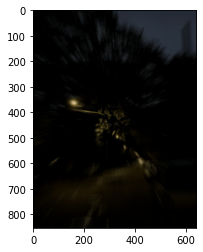

In [4]:
image_dir = './images'

img = cv2.cvtColor(cv2.imread(image_dir + '/1.png'), cv2.COLOR_BGR2RGB)
out = weather_augment("zoom", img)

plt.imshow(out)

In [61]:
def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def getOptimalKernelWidth1D(radius, sigma):
    return radius * 2 + 1

def gauss_function(x, mean, sigma):
    return (np.exp(- x**2 / (2 * (sigma**2)))) / (np.sqrt(2 * np.pi) * sigma)

def plasma_fractal(mapsize=256, wibbledecay=3):
    """
    Generate a heightmap using diamond-square algorithm.
    Return square 2d array, side length 'mapsize', of floats in range 0-255.
    'mapsize' must be a power of two.
    """
    assert (mapsize & (mapsize - 1) == 0)
    maparray = np.empty((mapsize, mapsize), dtype=np.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100

    def wibbledmean(array):
        return array / 4 + wibble * np.random.uniform(-wibble, wibble,
                                                      array.shape)

    def fillsquares():
        """For each square of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + np.roll(cornerref, shift=-1, axis=0)
        squareaccum += np.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)

    def filldiamonds():
        """For each diamond of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + np.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + np.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + np.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + np.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = wibbledmean(ttsum)

    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def getMotionBlurKernel(width, sigma):
    k = gauss_function(np.arange(width), 0, sigma)
    Z = np.sum(k)
    return k/Z

def shift(image, dx, dy):
    if(dx < 0):
        shifted = np.roll(image, shift=image.shape[1]+dx, axis=1)
        shifted[:,dx:] = shifted[:,dx-1:dx]
    elif(dx > 0):
        shifted = np.roll(image, shift=dx, axis=1)
        shifted[:,:dx] = shifted[:,dx:dx+1]
    else:
        shifted = image

    if(dy < 0):
        shifted = np.roll(shifted, shift=image.shape[0]+dy, axis=0)
        shifted[dy:,:] = shifted[dy-1:dy,:]
    elif(dy > 0):
        shifted = np.roll(shifted, shift=dy, axis=0)
        shifted[:dy,:] = shifted[dy:dy+1,:]
    return shifted

In [62]:
def fog(x, severity=1):
    c = [(1.5, 2), (2., 2), (2.5, 1.7), (2.5, 1.5), (3., 1.4)][severity - 1]

    shape = np.array(x).shape
    max_side = np.max(shape)
    map_size = next_power_of_2(int(max_side))

    x = np.array(x) / 255.
    max_val = x.max()

    x_shape = np.array(x).shape
    if len(x_shape) < 3 or x_shape[2] < 3:
        x += c[0] * plasma_fractal(mapsize=map_size, wibbledecay=c[1])[
                    :shape[0], :shape[1]]
    else:
        x += c[0] * \
             plasma_fractal(mapsize=map_size, wibbledecay=c[1])[:shape[0],
             :shape[1]][..., np.newaxis]
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255

def frost(x, severity=1):
    c = [(1, 0.4),
         (0.8, 0.6),
         (0.7, 0.7),
         (0.65, 0.7),
         (0.6, 0.75)][severity - 1]

    idx = np.random.randint(5)
    filename = [resource_filename(__name__, './frost/frost1.png'),
                resource_filename(__name__, './frost/frost2.png'),
                resource_filename(__name__, './frost/frost3.png'),
                resource_filename(__name__, './frost/frost4.jpg'),
                resource_filename(__name__, './frost/frost5.jpg'),
                resource_filename(__name__, './frost/frost6.jpg')][idx]
    frost = cv2.imread(filename)
    frost_shape = frost.shape
    x_shape = np.array(x).shape

    # resize the frost image so it fits to the image dimensions
    scaling_factor = 1
    if frost_shape[0] >= x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = 1
    elif frost_shape[0] < x_shape[0] and frost_shape[1] >= x_shape[1]:
        scaling_factor = x_shape[0] / frost_shape[0]
    elif frost_shape[0] >= x_shape[0] and frost_shape[1] < x_shape[1]:
        scaling_factor = x_shape[1] / frost_shape[1]
    elif frost_shape[0] < x_shape[0] and frost_shape[1] < x_shape[
        1]:  # If both dims are too small, pick the bigger scaling factor
        scaling_factor_0 = x_shape[0] / frost_shape[0]
        scaling_factor_1 = x_shape[1] / frost_shape[1]
        scaling_factor = np.maximum(scaling_factor_0, scaling_factor_1)

    scaling_factor *= 1.1
    new_shape = (int(np.ceil(frost_shape[1] * scaling_factor)),
                 int(np.ceil(frost_shape[0] * scaling_factor)))
    frost_rescaled = cv2.resize(frost, dsize=new_shape,
                                interpolation=cv2.INTER_CUBIC)

    # randomly crop
    x_start, y_start = np.random.randint(0, frost_rescaled.shape[0] - x_shape[
        0]), np.random.randint(0, frost_rescaled.shape[1] - x_shape[1])

    if len(x_shape) < 3 or x_shape[2] < 3:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]]
        frost_rescaled = rgb2gray(frost_rescaled)
    else:
        frost_rescaled = frost_rescaled[x_start:x_start + x_shape[0],
                         y_start:y_start + x_shape[1]][..., [2, 1, 0]]
    return np.clip(c[0] * np.array(x) + c[1] * frost_rescaled, 0, 255)

def snow(x, severity=1):
    c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
         (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
         (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
         (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
         (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]

    x = np.array(x, dtype=np.float32) / 255.
    snow_layer = np.random.normal(size=x.shape[:2], loc=c[0],
                                  scale=c[1])  # [:2] for monochrome

    snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = np.clip(snow_layer.squeeze(), 0, 1)


    snow_layer = _motion_blur(snow_layer, radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    # The snow layer is rounded and cropped to the img dims
    snow_layer = np.round(snow_layer * 255).astype(np.uint8) / 255.
    snow_layer = snow_layer[..., np.newaxis]
    snow_layer = snow_layer[:x.shape[0], :x.shape[1], :]

    if len(x.shape) < 3 or x.shape[2] < 3:
        x = c[6] * x + (1 - c[6]) * np.maximum(x, x.reshape(x.shape[0],
                                                            x.shape[
                                                                1]) * 1.5 + 0.5)
        snow_layer = snow_layer.squeeze(-1)
    else:
        x = c[6] * x + (1 - c[6]) * np.maximum(x, cv2.cvtColor(x,
                                                               cv2.COLOR_RGB2GRAY).reshape(
            x.shape[0], x.shape[1], 1) * 1.5 + 0.5)
    try:
        return np.clip(x + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255
    except ValueError:
        print('ValueError for Snow, Exception handling')
        x[:snow_layer.shape[0], :snow_layer.shape[1]] += snow_layer + np.rot90(
            snow_layer, k=2)
        return np.clip(x, 0, 1) * 255
    
def clipped_zoom(img, zoom_factor):
    # clipping along the width dimension:
    ch0 = int(np.ceil(img.shape[0] / float(zoom_factor)))
    top0 = (img.shape[0] - ch0) // 2

    # clipping along the height dimension:
    ch1 = int(np.ceil(img.shape[1] / float(zoom_factor)))
    top1 = (img.shape[1] - ch1) // 2

    img = scizoom(img[top0:top0 + ch0, top1:top1 + ch1],
                  (zoom_factor, zoom_factor, 1), order=1)

    return img

def _motion_blur(x, radius, sigma, angle):
    width = getOptimalKernelWidth1D(radius, sigma)
    kernel = getMotionBlurKernel(width, sigma)
    point = (width * np.sin(np.deg2rad(angle)), width * np.cos(np.deg2rad(angle)))
    hypot = math.hypot(point[0], point[1])

    blurred = np.zeros_like(x, dtype=np.float32)
    for i in range(width):
        dy = -math.ceil(((i*point[0]) / hypot) - 0.5)
        dx = -math.ceil(((i*point[1]) / hypot) - 0.5)
        if (np.abs(dy) >= x.shape[0] or np.abs(dx) >= x.shape[1]):
            # simulated motion exceeded image borders
            break
        shifted = shift(x, dx, dy)
        blurred = blurred + kernel[i] * shifted
    return blurred

def zoom_blur(x, severity=1):
    c = [np.arange(1, 1.11, 0.01),
         np.arange(1, 1.16, 0.01),
         np.arange(1, 1.21, 0.02),
         np.arange(1, 1.26, 0.02),
         np.arange(1, 1.31, 0.03)][severity - 1]

    x = (np.array(x) / 255.).astype(np.float32)
    out = np.zeros_like(x)

    set_exception = False
    for zoom_factor in c:
        if len(x.shape) < 3 or x.shape[2] < 3:
            x_channels = np.array([x, x, x]).transpose((1, 2, 0))
            zoom_layer = clipped_zoom(x_channels, zoom_factor)
            zoom_layer = zoom_layer[:x.shape[0], :x.shape[1], 0]
        else:
            zoom_layer = clipped_zoom(x, zoom_factor)
            zoom_layer = zoom_layer[:x.shape[0], :x.shape[1], :]

        try:
            out += zoom_layer
        except ValueError:
            set_exception = True
            out[:zoom_layer.shape[0], :zoom_layer.shape[1]] += zoom_layer

    if set_exception:
        print('ValueError for zoom blur, Exception handling')
    x = (x + out) / (len(c) + 1)
    return np.clip(x, 0, 1) * 255

In [ ]:
def _find_edges_canny(image, edge_multiplier, from_colorspace):
    image_gray = colorlib.change_colorspace_(np.copy(image),
                                             to_colorspace=colorlib.CSPACE_GRAY,
                                             from_colorspace=from_colorspace)
    image_gray = image_gray[..., 0]
    thresh = min(int(200 * (1/edge_multiplier)), 254)
    edges = cv2.Canny(_normalize_cv2_input_arr_(image_gray), thresh, thresh)
    return edges


# Added in 0.4.0.
def _find_edges_laplacian(image, edge_multiplier, from_colorspace):
    image_gray = colorlib.change_colorspace_(np.copy(image),
                                             to_colorspace=colorlib.CSPACE_GRAY,
                                             from_colorspace=from_colorspace)
    image_gray = image_gray[..., 0]
    edges_f = cv2.Laplacian(_normalize_cv2_input_arr_(image_gray / 255.0),
                            cv2.CV_64F)
    edges_f = np.abs(edges_f)
    edges_f = edges_f ** 2
    vmax = np.percentile(edges_f, min(int(90 * (1/edge_multiplier)), 99))
    edges_f = np.clip(edges_f, 0.0, vmax) / vmax

    edges_uint8 = np.clip(np.round(edges_f * 255), 0, 255.0).astype(np.uint8)
    edges_uint8 = _blur_median(edges_uint8, 3)
    edges_uint8 = _threshold(edges_uint8, 50)
    return edges_uint8


# Added in 0.4.0.
def _blur_median(image, ksize):
    if ksize % 2 == 0:
        ksize += 1
    if ksize <= 1:
        return image
    return cv2.medianBlur(_normalize_cv2_input_arr_(image), ksize)


# Added in 0.4.0.
def _threshold(image, thresh):
    mask = (image < thresh)
    result = np.copy(image)
    result[mask] = 0
    return result


# Added in 0.4.0.
def _suppress_edge_blobs(edges, size, thresh, inverse):
    kernel = np.ones((size, size), dtype=np.float32)
    counts = cv2.filter2D(_normalize_cv2_input_arr_(edges / 255.0), -1, kernel)

    if inverse:
        mask = (counts < thresh)
    else:
        mask = (counts >= thresh)

    edges = np.copy(edges)
    edges[mask] = 0
    return edges


# Added in 0.4.0.
def _saturate(image, factor, from_colorspace):
    image = np.copy(image)
    if np.isclose(factor, 1.0, atol=1e-2):
        return image

    hsv = colorlib.change_colorspace_(image,
                                      to_colorspace=colorlib.CSPACE_HSV,
                                      from_colorspace=from_colorspace)
    sat = hsv[:, :, 1]
    sat = np.clip(sat.astype(np.int32) * factor, 0, 255).astype(np.uint8)
    hsv[:, :, 1] = sat
    image_sat = colorlib.change_colorspace_(hsv,
                                            to_colorspace=from_colorspace,
                                            from_colorspace=colorlib.CSPACE_HSV)
    return image_sat


# Added in 0.4.0.
def _blend_edges(image, image_edges):
    image_edges = 1.0 - (image_edges / 255.0)
    image_edges = np.tile(image_edges[..., np.newaxis], (1, 1, 3))
    return np.clip(
        np.round(image * image_edges),
        0.0, 255.0
    ).astype(np.uint8)



def stylize_cartoon(image, blur_ksize=3, segmentation_size=1.0,
                    saturation=2.0, edge_prevalence=1.0,
                    suppress_edges=True,
                    from_colorspace=colorlib.CSPACE_RGB):
    iadt.allow_only_uint8({image.dtype})

    assert image.ndim == 3 and image.shape[2] == 3, (
        "Expected to get a (H,W,C) image, got shape %s." % (image.shape,))

    blur_ksize = max(int(np.round(blur_ksize)), 1)
    segmentation_size = max(segmentation_size, 0.0)
    saturation = max(saturation, 0.0)

    is_small_image = max(image.shape[0:2]) < 400

    image = _blur_median(image, blur_ksize)
    image_seg = np.zeros_like(image)

    if is_small_image:
        spatial_window_radius = int(10 * segmentation_size)
        color_window_radius = int(20 * segmentation_size)
    else:
        spatial_window_radius = int(15 * segmentation_size)
        color_window_radius = int(40 * segmentation_size)

    if segmentation_size <= 0:
        image_seg = image
    else:
        cv2.pyrMeanShiftFiltering(_normalize_cv2_input_arr_(image),
                                  sp=spatial_window_radius,
                                  sr=color_window_radius,
                                  dst=image_seg)

    if is_small_image:
        edges_raw = _find_edges_canny(image_seg,
                                      edge_prevalence,
                                      from_colorspace)
    else:
        edges_raw = _find_edges_laplacian(image_seg,
                                          edge_prevalence,
                                          from_colorspace)

    edges = edges_raw

    edges = ((edges > 100) * 255).astype(np.uint8)

    if suppress_edges:
        # Suppress dense 3x3 blobs full of detected edges. They are visually
        # ugly.
        edges = _suppress_edge_blobs(edges, 3, 8, inverse=False)

        # Suppress spurious few-pixel edges (5x5 size with <=3 edge pixels).
        edges = _suppress_edge_blobs(edges, 5, 3, inverse=True)

    return _saturate(_blend_edges(image_seg, edges),
                     saturation,
                     from_colorspace)

In [6]:
start = time.time()
for i in range(1000):
    img = np.zeros((512,512,3), np.uint8) + 255
    out = np.uint8(weather_augment('clouds', img))
end = time.time()
print("Time elapsed:", end - start, "sec")

Time elapsed: 169.04166412353516 sec


In [19]:
cv2.imshow('0', out)
cv2.waitKey(0)

-1